In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, RNN, GRU
from keras.layers import Dense

Data Processing

In [0]:
df = pd.read_csv("Foreign_Exchange_Rates.csv")
df = df.drop(columns=["Unnamed: 0"])
df.columns = list(map(lambda x: x.split(" - ")[0] if "-" in x else "DATE", df.columns))

df = df.set_index("DATE")
df.index = pd.to_datetime(df.index)


n_records = (df.index.max() - df.index.min()).days+1


dates = dict()
dates["DATE"] = pd.date_range(df.index.min().date(), df.index.max().date(), freq="D") #freq by days

dataset = pd.DataFrame(data = dates)
dataset = dataset.set_index("DATE")
dataset = dataset.merge(df, left_index=True, right_index=True, how="left")

dataset = dataset.replace("ND", np.nan)
dataset = dataset.bfill().ffill()
dataset = dataset.astype(float)

In [0]:
dataset.head()

Plot Dataset

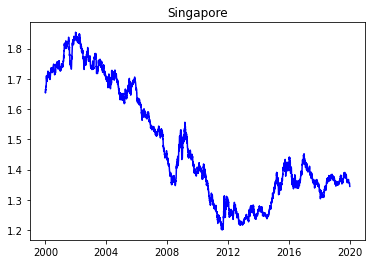

In [6]:
plt.plot(dataset['SINGAPORE'], color = 'b')
plt.title('Singapore')
plt.show()

Creating Proper Input and Output

In [0]:
def getTimeSeriesData(A, window=7): #default window value -> number of days in a week
    X, Y = list(), list()
    for i in range(len(A)):
        end_point = i + window
        if end_point > len(A) - 1:
            break
        X.append(A[i:end_point])
        Y.append(A[end_point])

    return np.array(X), np.array(Y)

LSTM and GRU Model

In [13]:
window = 2
n_features = 1 

X, Y = getTimeSeriesData(list(dataset["INDIA"]), window)
X = X.reshape((X.shape[0], X.shape[1], n_features))
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle = False)



lstm_model = Sequential()
lstm_model.add(LSTM(7, activation='relu', input_shape=(window, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_train_history = lstm_model.fit(x_train, y_train, epochs=10, verbose=1)

gru_model = Sequential()
gru_model.add(GRU(7, activation='relu', input_shape=(window, n_features)))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mse')
gru_train_history = gru_model.fit(x_train, y_train, epochs=10, verbose=1)


Epoch 1/10
5110/5110 [==============================] - 1s 113us/step - loss: 2300.0515
Epoch 2/10
5110/5110 [==============================] - 0s 65us/step - loss: 22.1568
Epoch 3/10
5110/5110 [==============================] - 0s 66us/step - loss: 0.2333
Epoch 4/10
5110/5110 [==============================] - 0s 66us/step - loss: 0.2289
Epoch 5/10
5110/5110 [==============================] - 0s 65us/step - loss: 0.2242
Epoch 6/10
5110/5110 [==============================] - 0s 66us/step - loss: 0.2194
Epoch 7/10
5110/5110 [==============================] - 0s 66us/step - loss: 0.2120
Epoch 8/10
5110/5110 [==============================] - 0s 65us/step - loss: 0.2045
Epoch 9/10
5110/5110 [==============================] - 0s 64us/step - loss: 0.1974
Epoch 10/10
5110/5110 [==============================] - 0s 67us/step - loss: 0.1895
Epoch 1/10
5110/5110 [==============================] - 1s 124us/step - loss: 2818.6404
Epoch 2/10
5110/5110 [==============================] - 0s 67us/st

In [14]:
y_pred1 = lstm_model.predict(x_test, verbose=0)
y_pred1.shape = y_pred1.shape[0]

with tf.compat.v1.Session() as sess:
  test_loss = sess.run(tf.keras.losses.MSE(y_test, y_pred1))
  print("LSTM Test Loss:",test_loss )


y_pred2 = gru_model.predict(x_test, verbose=0)
y_pred2.shape = y_pred2.shape[0]

with tf.compat.v1.Session() as sess:
  test_loss = sess.run(tf.keras.losses.MSE(y_test, y_pred2))
  print("GRU Test Loss:",test_loss )

LSTM Test Loss: 2.9289408
GRU Test Loss: 0.13351846


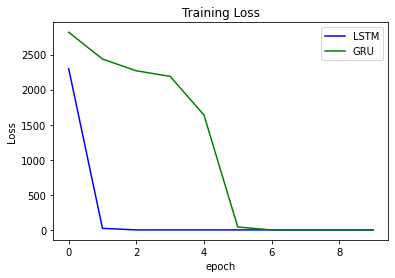

In [15]:
#plotting loss function
plt.plot(lstm_train_history.history["loss"], color = 'b')
plt.plot(gru_train_history.history["loss"], color = 'g')
plt.title("Training Loss")
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['LSTM', 'GRU'], loc='upper right')
plt.show()

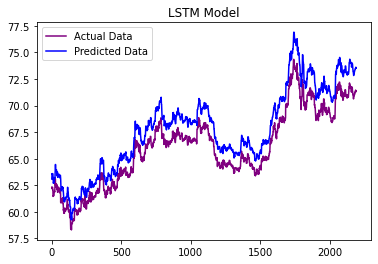

In [16]:
plt.plot(y_test, color = 'purple')
plt.plot(y_pred1, color = 'b')
plt.title("LSTM Model")

plt.legend(['Actual Data', 'Predicted Data'], loc='upper left')

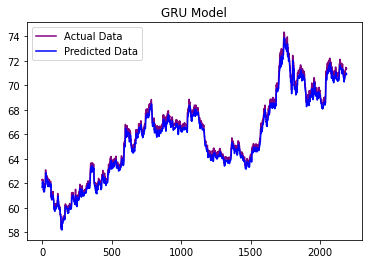

In [17]:
plt.plot(y_test, color = 'purple')
plt.plot(y_pred2, color = 'b')
plt.title("GRU Model")

plt.legend(['Actual Data', 'Predicted Data'], loc='upper left')